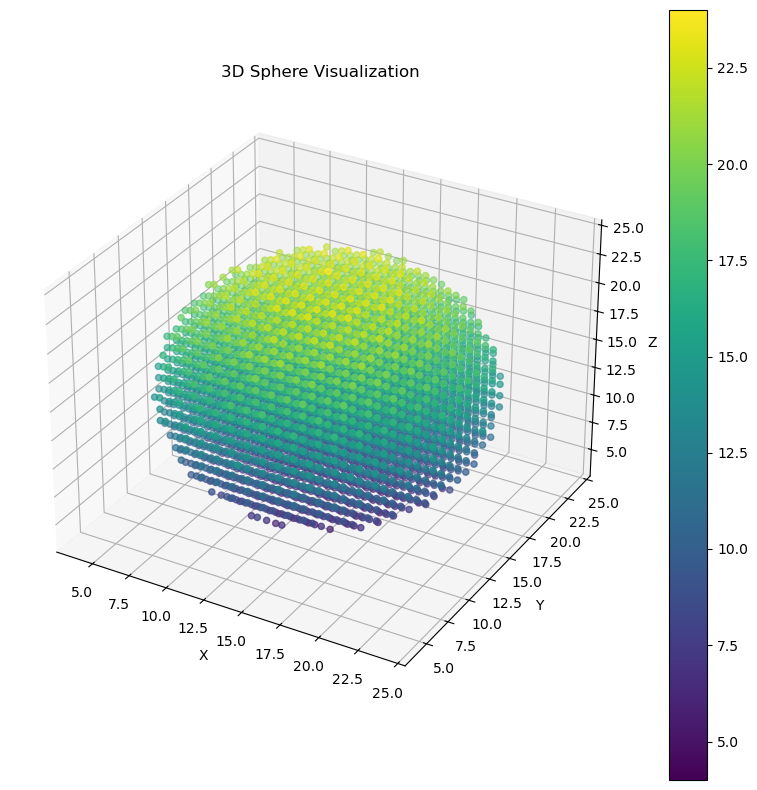

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D array (30x30x30) with a sphere pattern
x, y, z = np.indices((30, 30, 30))
center = (14, 14, 14)
radius = 10
sphere = (x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2 <= radius**2
data = np.zeros((30, 30, 30))
data[sphere] = 1

# Create figure and 3D axis
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Get the voxel coordinates where value is 1
x, y, z = data.nonzero()

# Plot the 3D points
scatter = ax.scatter(x, y, z, c=z, cmap='viridis')
plt.colorbar(scatter)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Sphere Visualization')

# Show the plot
plt.show()


In [5]:
data.shape

(30, 30, 30)

In [ ]:
# Read in image
# 3D image data
image = data

# Split into suare

def crop_polygon_to_non_overlapping_squares(Image, cubic_size):
    """
    Crops a polygon into non-overlapping square regions of a given size.

    Args:
        Image (rectangular): The input 3D numpy array to crop.
        cubic_size (float): The size of each cubic region (side length).

    Returns:
        List[Polygon]: List of non-overlapping square polygons that fully contain the polygon.
    """

    # Get bounding box of the polygon
    minx, miny, maxx, maxy = rectangular.bounds

    # Generate grid of squares
    squares = []

    
    return squares



Original shape: (30, 30, 30)
Number of cubic regions: 27
Shape of each cubic region: (10, 10, 10)


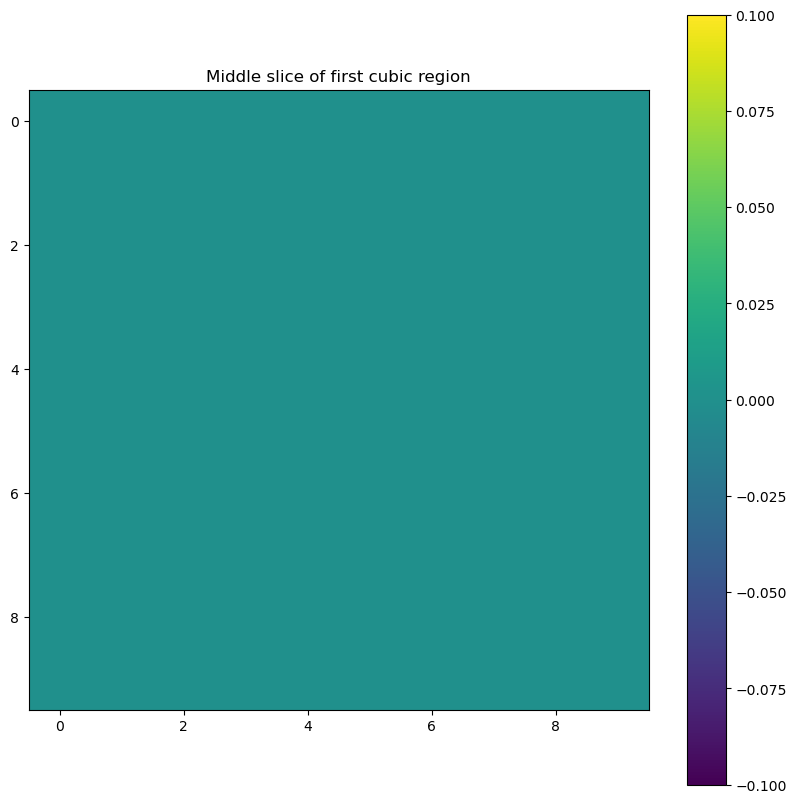

In [16]:
import numpy as np

def crop_3d_array_to_cubes(image, cubic_size):
    """
    Splits a 3D numpy array into non-overlapping cubic regions.
    
    Args:
        image (np.ndarray): The input 3D numpy array
        cubic_size (int): The size of each cubic region (side length)
        
    Returns:
        List of cubic regions as numpy arrays
    """
    # Get image dimensions
    depth, height, width = image.shape
    
    # Calculate number of cubes in each dimension
    num_d = (depth + cubic_size - 1) // cubic_size
    num_h = (height + cubic_size - 1) // cubic_size
    num_w = (width + cubic_size - 1) // cubic_size
    
    # Initialize list to store cubic regions
    cubes = []
    
    # Split image into cubic regions
    for d in range(num_d):
        for h in range(num_h):
            for w in range(num_w):
                # Calculate start and end indices
                d_start = d * cubic_size
                h_start = h * cubic_size
                w_start = w * cubic_size
                
                d_end = min(d_start + cubic_size, depth)
                h_end = min(h_start + cubic_size, height)
                w_end = min(w_start + cubic_size, width)
                
                # Extract cubic region
                cube = image[d_start:d_end, h_start:h_end, w_start:w_end]
                
                # Pad if necessary to maintain consistent size
                if cube.shape != (cubic_size, cubic_size, cubic_size):
                    padded_cube = np.zeros((cubic_size, cubic_size, cubic_size))
                    padded_cube[:cube.shape[0], :cube.shape[1], :cube.shape[2]] = cube
                    cube = padded_cube
                
                cubes.append(cube)
    
    return cubes

# Example usage
if __name__ == "__main__":
    
    # Using 3D simulated data
    data = data
    
    # Split into cubic regions
    cubic_size = 10
    cubic_regions = crop_3d_array_to_cubes(data, cubic_size)
    
    # Print information about the results
    print(f"Original shape: {data.shape}")
    print(f"Number of cubic regions: {len(cubic_regions)}")
    print(f"Shape of each cubic region: {cubic_regions[0].shape}")
    
    # Visualize a cubic region (optional)
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cubic_regions[0][cubic_size//2])
    plt.title(f"Middle slice of first cubic region")
    plt.colorbar()
    plt.show()


Number of cubes: 27
cube[1]':  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Cube 0 shape: (10, 10, 10)
Cube 1 shape: (10, 10, 10)
Cube 2 shape: (10, 10, 10)
Cube 3 shape: (10, 10, 10)
Cube 4 shape: (10, 10, 10)
Cube 5 shape: (10, 10, 10)
Cube 6 shape: (10, 10, 10)
Cube 7 shape: (10, 10, 10)
Cube 8 shape: (10, 10, 10)
Cube 9 shape: (10, 10, 10)


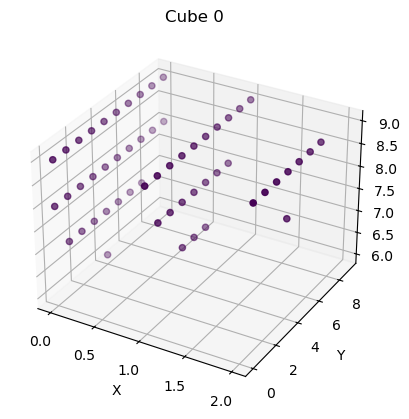

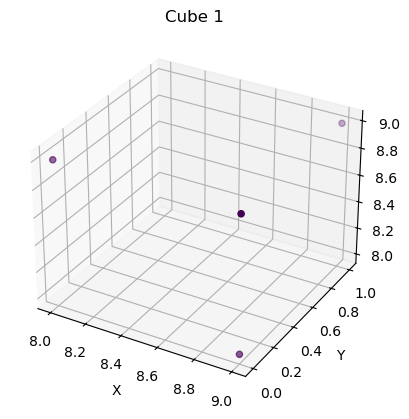

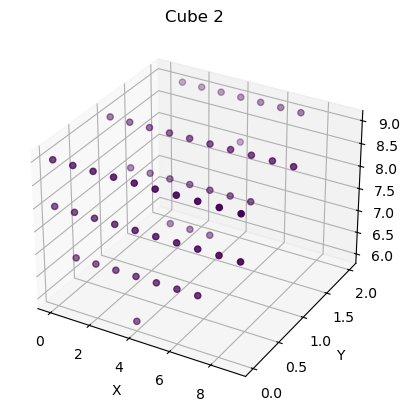

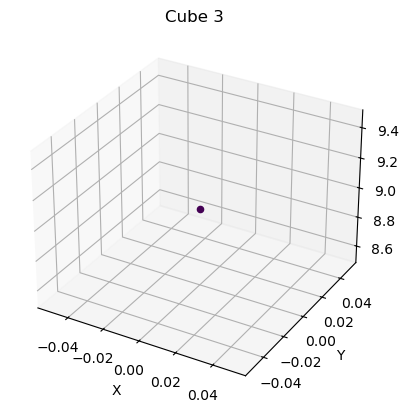

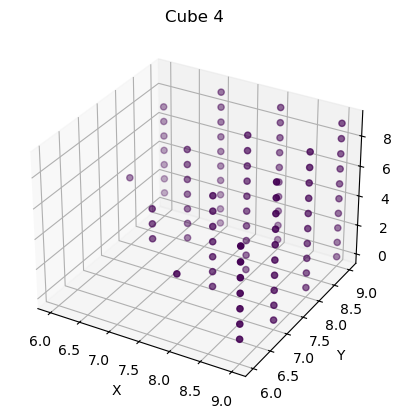

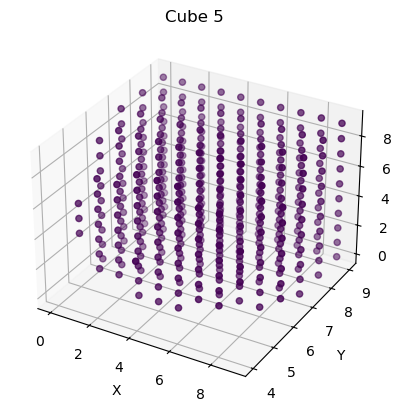

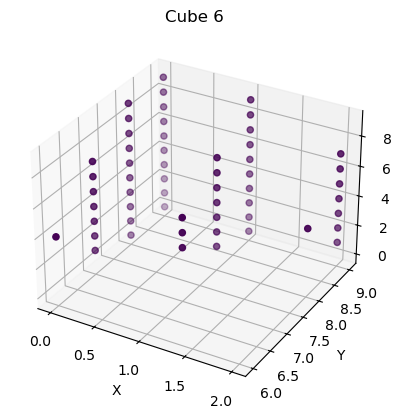

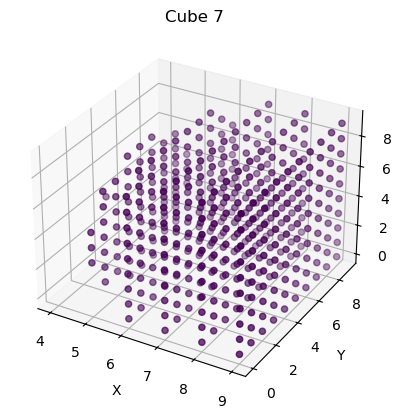

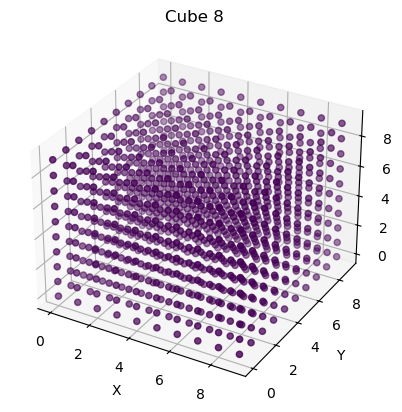

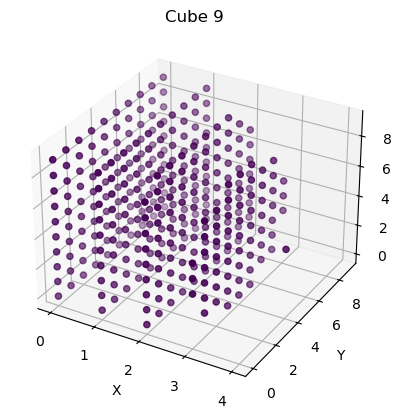

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def crop_array_to_non_overlapping_cubes(image, cubic_size):
    """
    Crops a 3D array into non-overlapping cubic regions of a given size.

    Args:
        image (np.ndarray): The input 3D numpy array to crop.
        cubic_size (int): The size of each cubic region (side length).

    Returns:
        List[np.ndarray]: List of non-overlapping cubic regions.
    """
    if len(image.shape) != 3:
        raise ValueError("Input image must be a 3D numpy array.")

    # Get dimensions of the input image
    depth, height, width = image.shape

    # Calculate the number of cubes in each dimension
    num_cubes_depth = depth // cubic_size
    num_cubes_height = height // cubic_size
    num_cubes_width = width // cubic_size

    cubes = []

    # Iterate over the grid and extract cubic regions
    for d in range(num_cubes_depth):
        for h in range(num_cubes_height):
            for w in range(num_cubes_width):
                start_d = d * cubic_size
                start_h = h * cubic_size
                start_w = w * cubic_size

                cube = image[start_d:start_d + cubic_size, 
                             start_h:start_h + cubic_size, 
                             start_w:start_w + cubic_size]
                cubes.append(cube)

    return cubes

def plot_cubes(cubes):
    """
    Plots the first few cubic regions in 3D.

    Args:
        cubes (List[np.ndarray]): List of cubic regions to plot.
    """
    for i, cube in enumerate(cubes[5:15]):  # Limit to the first 5 cubes for visualization
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Create a grid of coordinates for the cube
        z, y, x = np.nonzero(cube)

        ax.scatter(x, y, z, c=cube[z, y, x], cmap='viridis')
        ax.set_title(f"Cube {i}")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")

        plt.show()

# Example usage
# image = np.random.rand(50, 50, 50)  # Example 3D image
image = data

cubic_size = 10
cubes = crop_array_to_non_overlapping_cubes(image, cubic_size)

print(f"Number of cubes: {len(cubes)}")
print("cube[1]': ", cubes[17][7][8])
for i, cube in enumerate(cubes[5:15]):  # Display the first few cubes
    print(f"Cube {i} shape: {cube.shape}")

plot_cubes(cubes)


In [34]:
import numpy as np

def crop_array_to_non_overlapping_cubes(image, cubic_size):
    """
    Crops a 3D array into non-overlapping cubic regions of a given size.

    Args:
        image (np.ndarray): The input 3D numpy array to crop.
        cubic_size (int): The size of each cubic region (side length).

    Returns:
        List[np.ndarray]: List of non-overlapping cubic regions.
    """
    if len(image.shape) != 3:
        raise ValueError("Input image must be a 3D numpy array.")

    # Get dimensions of the input image
    depth, height, width = image.shape

    # Calculate the number of cubes in each dimension
    num_cubes_depth = depth // cubic_size
    num_cubes_height = height // cubic_size
    num_cubes_width = width // cubic_size

    cubes = []

    # Iterate over the grid and extract cubic regions
    for d in range(num_cubes_depth):
        for h in range(num_cubes_height):
            for w in range(num_cubes_width):
                start_d = d * cubic_size
                start_h = h * cubic_size
                start_w = w * cubic_size

                cube = image[start_d:start_d + cubic_size, 
                             start_h:start_h + cubic_size, 
                             start_w:start_w + cubic_size]
                cubes.append(cube)

    return cubes

# Example usage
# image = np.random.rand(50, 50, 50)  # Example 3D image
image = data

cubic_size = 10
cubes = crop_array_to_non_overlapping_cubes(image, cubic_size)

print(f"Number of cubes: {len(cubes)}")

for i, cube in enumerate(cubes[:5]):  # Display the first few cubes
    print(f"Cube {i} shape: {cube.shape}")

# plot each cube [Cubic_original]

# for each cubic, make a new list of cubics boundaries with the overlap region of 10 pixels

# for each cubic, plot cubic [Cubic_original] and cubic [Cubic_overlap]

# In there, for each cubic [Cubic_original], make a new list of cubics boundaries  [Cubic_overlap] with the overlap region



Number of cubes: 27
cube[1]':  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Cube 0 shape: (10, 10, 10)
Cube 1 shape: (10, 10, 10)
Cube 2 shape: (10, 10, 10)
Cube 3 shape: (10, 10, 10)
Cube 4 shape: (10, 10, 10)


Number of original cubes: 64
Original Cube 0 shape: (10, 10, 10), Boundaries: [0, 10, 0, 10, 0, 10]
Original Cube 1 shape: (10, 10, 10), Boundaries: [0, 10, 0, 10, 6, 16]
Original Cube 2 shape: (10, 10, 10), Boundaries: [0, 10, 0, 10, 12, 22]
Original Cube 3 shape: (10, 10, 10), Boundaries: [0, 10, 0, 10, 18, 28]
Original Cube 4 shape: (10, 10, 10), Boundaries: [0, 10, 6, 16, 0, 10]
Number of overlapping cubes: 64
Overlapping Cube 0 shape: (14, 14, 14), Boundaries: [0, 14, 0, 14, 0, 14]
Overlapping Cube 1 shape: (14, 14, 18), Boundaries: [0, 14, 0, 14, 2, 20]
Overlapping Cube 2 shape: (14, 14, 18), Boundaries: [0, 14, 0, 14, 8, 26]
Overlapping Cube 3 shape: (14, 14, 16), Boundaries: [0, 14, 0, 14, 14, 30]
Overlapping Cube 4 shape: (14, 18, 14), Boundaries: [0, 14, 2, 20, 0, 14]


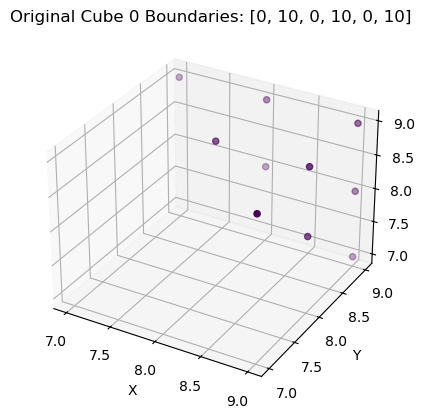

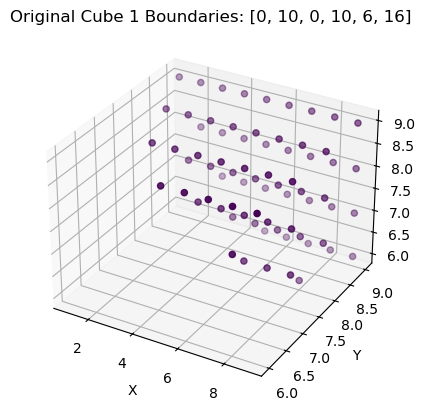

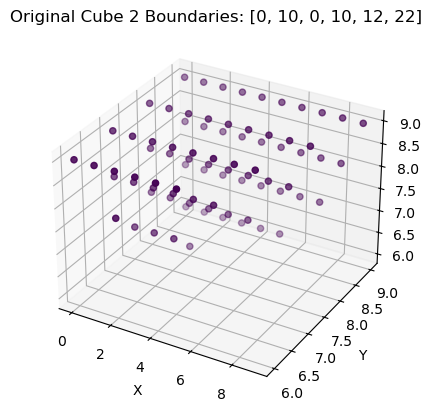

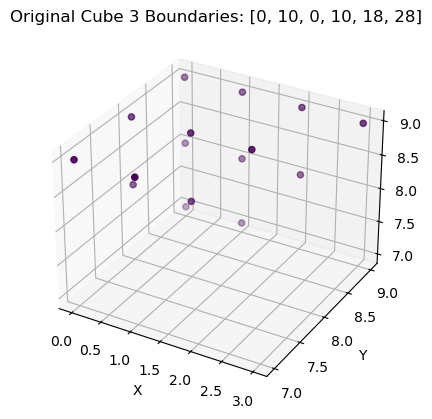

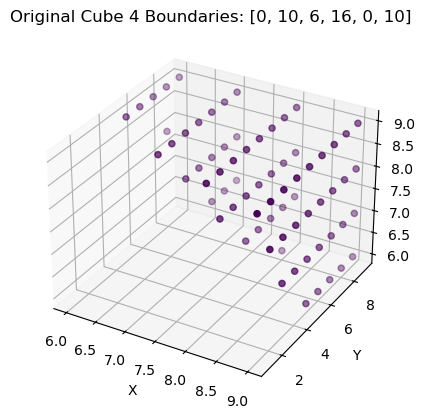

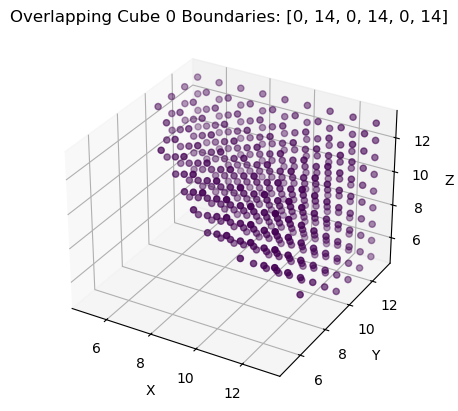

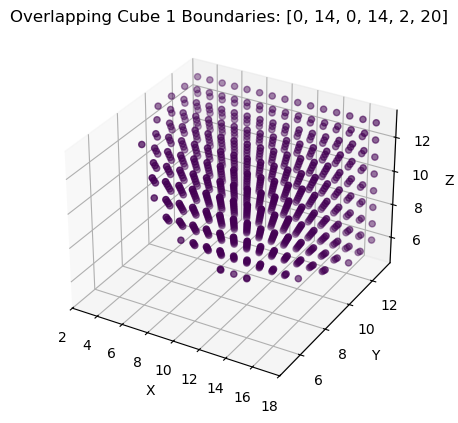

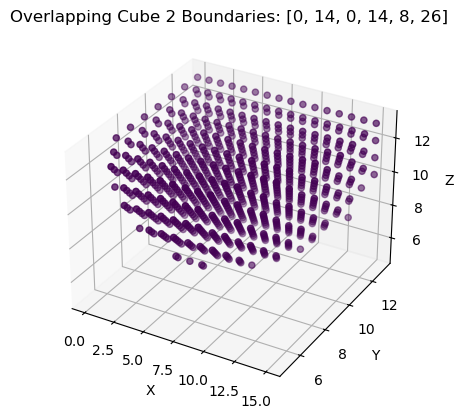

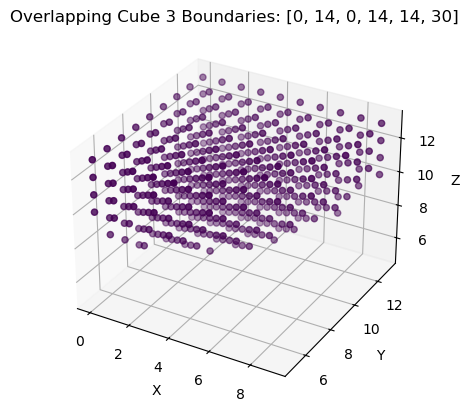

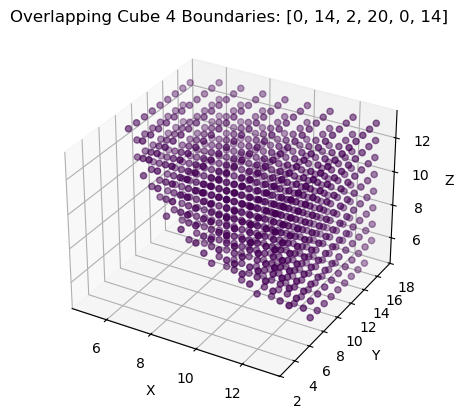

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def crop_array_to_overlapping_cubes(image, cubic_size, overlap):
    """
    Crops a 3D array into overlapping cubic regions of a given size.

    Args:
        image (np.ndarray): The input 3D numpy array to crop.
        cubic_size (int): The size of each cubic region (side length).
        overlap (int): The number of pixels to overlap between adjacent cubes.

    Returns:
        List[Tuple[np.ndarray, List[int]]]: List of overlapping cubic regions and their boundaries.
    """
    if len(image.shape) != 3:
        raise ValueError("Input image must be a 3D numpy array.")

    if overlap >= cubic_size:
        raise ValueError("Overlap must be smaller than cubic_size.")

    # Get dimensions of the input image
    depth, height, width = image.shape

    # Calculate the step size considering overlap
    step = cubic_size - overlap

    cubes = []
    overlapping_cubes = []

    # Iterate over the grid and extract overlapping cubic regions
    for d in range(0, depth - cubic_size + 1, step):
        for h in range(0, height - cubic_size + 1, step):
            for w in range(0, width - cubic_size + 1, step):
                start_d = d
                start_h = h
                start_w = w

                end_d = start_d + cubic_size
                end_h = start_h + cubic_size
                end_w = start_w + cubic_size

                cube = image[start_d:end_d, start_h:end_h, start_w:end_w]
                cubes.append((cube, [start_d, end_d, start_h, end_h, start_w, end_w]))

                # Define overlapping boundaries
                overlap_start_d = max(0, start_d - overlap)
                overlap_start_h = max(0, start_h - overlap)
                overlap_start_w = max(0, start_w - overlap)

                overlap_end_d = min(depth, end_d + overlap)
                overlap_end_h = min(height, end_h + overlap)
                overlap_end_w = min(width, end_w + overlap)

                cube_overlap = image[overlap_start_d:overlap_end_d, overlap_start_h:overlap_end_h, overlap_start_w:overlap_end_w]
                overlapping_cubes.append((cube_overlap, [overlap_start_d, overlap_end_d, overlap_start_h, overlap_end_h, overlap_start_w, overlap_end_w]))

    return cubes, overlapping_cubes

def plot_cubes(cubes, title_prefix="Cube"):
    """
    Plots the first few cubic regions in 3D.

    Args:
        cubes (List[np.ndarray]): List of cubic regions to plot.
        title_prefix (str): Prefix for the plot titles.
    """
    for i, (cube, boundaries) in enumerate(cubes[:5]):  # Limit to the first 5 cubes for visualization
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Create a grid of coordinates for the cube
        z, y, x = np.nonzero(cube)

        ax.scatter(x, y, z, c=cube[z, y, x], cmap='viridis')
        ax.set_title(f"{title_prefix} {i} Boundaries: {boundaries}")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")

        plt.show()

# Example usage
# image = np.random.rand(50, 50, 50)  # Example 3D image

image = data

cubic_size = 10
overlap = 4
cubes, overlapping_cubes = crop_array_to_overlapping_cubes(image, cubic_size, overlap)

print(f"Number of original cubes: {len(cubes)}")
for i, (cube, boundaries) in enumerate(cubes[:5]):  # Display the first few original cubes
    print(f"Original Cube {i} shape: {cube.shape}, Boundaries: {boundaries}")

print(f"Number of overlapping cubes: {len(overlapping_cubes)}")
for i, (cube_overlap, boundaries) in enumerate(overlapping_cubes[:5]):  # Display the first few overlapping cubes
    print(f"Overlapping Cube {i} shape: {cube_overlap.shape}, Boundaries: {boundaries}")

# Plot original cubes
plot_cubes(cubes, title_prefix="Original Cube")

# Plot overlapping cubes
plot_cubes(overlapping_cubes, title_prefix="Overlapping Cube")



In [17]:
cubic_regions

[array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
 
        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.

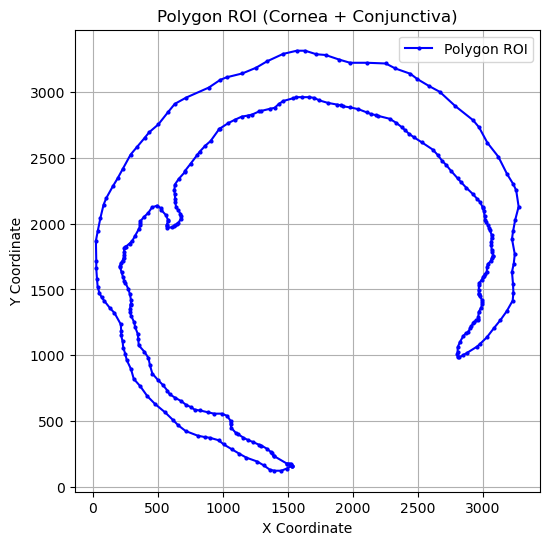

In [6]:
import pandas as pd
# Read the coordinates from the CSV file
polygonCoords_csv = r'G:/Alexis_data/Project/ST_image/input_files/1823od_corneasection.csv'
polygon_coords = pd.read_csv(polygonCoords_csv)

# Extract the X and Y coordinates
x_coords = polygon_coords['X']
y_coords = polygon_coords['Y']

# Create a plot
plt.figure(figsize=(6, 6))
plt.plot(x_coords, y_coords, marker='o', linestyle='-', color='b', label='Polygon ROI',  markersize=2)

# Close the polygon by connecting the last point to the first
plt.plot([x_coords.iloc[0], x_coords.iloc[-1]], [y_coords.iloc[0], y_coords.iloc[-1]], 'b-')

# Adding labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Polygon ROI (Cornea + Conjunctiva)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [8]:
from shapely.geometry import Polygon, box

# Extract the X and Y coordinates
x_coords = polygon_coords['X'].to_list()
y_coords = polygon_coords['Y'].to_list()

# Combine X and Y into coordinate pairs
coordinate_pairs = list(zip(x_coords, y_coords))

# Create a Polygon object
polygon_roi = Polygon(coordinate_pairs)
print(polygon_roi)

POLYGON ((1391.64 234.77, 1375.47 256.33, 1370.08 264.42, 1340.43 288.67, 1297.31 312.93, 1281.14 318.32, 1232.63 339.88, 1192.21 356.05, 1159.87 372.22, 1119.44 399.17, 1100.58 409.95, 1065.54 447.68, 1060.15 480.02, 1060.15 501.58, 1033.2 539.31, 992.78 555.48, 933.49 555.48, 884.98 566.26, 825.69 579.73, 785.26 585.12, 758.31 603.99, 717.89 622.85, 682.85 649.8, 634.34 676.75, 591.22 703.7, 575.05 730.65, 540.02 773.77, 502.29 811.5, 459.17 860.01, 440.3 924.69, 429.52 978.59, 397.18 1027.1, 354.06 1075.61, 351.37 1121.43, 345.98 1164.55, 327.11 1213.06, 319.03 1250.79, 297.47 1296.6, 286.69 1326.25, 286.69 1350.5, 292.08 1382.84, 294.77 1390.93, 294.77 1420.57, 286.69 1463.69, 273.21 1506.81, 251.65 1549.93, 243.57 1563.41, 232.79 1595.75, 222.01 1630.78, 211.23 1671.21, 211.23 1681.99, 216.62 1698.16, 230.09 1719.72, 238.18 1741.28, 240.87 1760.14, 240.87 1784.4, 243.57 1811.35, 251.65 1824.82, 254.35 1824.82, 283.99 1849.08, 305.55 1870.64, 327.11 1908.37, 354.06 1956.88, 367.54 

In [9]:
def crop_polygon_to_non_overlapping_squares(polygon, square_size):
    """
    Crops a polygon into non-overlapping square regions of a given size.

    Args:
        polygon (Polygon): The input polygon to crop.
        square_size (float): The size of each square region (side length).

    Returns:
        List[Polygon]: List of non-overlapping square polygons that fully contain the polygon.
    """
    # Get bounding box of the polygon
    minx, miny, maxx, maxy = polygon.bounds

    # Generate grid of squares
    squares = []
    for x in range(int(minx), int(maxx), square_size):
        for y in range(int(miny), int(maxy), square_size):
            square = box(x, y, x + square_size, y + square_size)
            # Check if the square intersects the polygon
            if polygon.intersects(square):
                squares.append(square)
    
    return squares

square: POLYGON ((525 121, 525 621, 25 621, 25 121, 525 121))
 x: array('d', [525.0, 525.0, 25.0, 25.0, 525.0]) 
 y: array('d', [121.0, 621.0, 621.0, 121.0, 121.0])
square: POLYGON ((525 621, 525 1121, 25 1121, 25 621, 525 621))
 x: array('d', [525.0, 525.0, 25.0, 25.0, 525.0]) 
 y: array('d', [621.0, 1121.0, 1121.0, 621.0, 621.0])
square: POLYGON ((525 1121, 525 1621, 25 1621, 25 1121, 525 1121))
 x: array('d', [525.0, 525.0, 25.0, 25.0, 525.0]) 
 y: array('d', [1121.0, 1621.0, 1621.0, 1121.0, 1121.0])
square: POLYGON ((525 1621, 525 2121, 25 2121, 25 1621, 525 1621))
 x: array('d', [525.0, 525.0, 25.0, 25.0, 525.0]) 
 y: array('d', [1621.0, 2121.0, 2121.0, 1621.0, 1621.0])
square: POLYGON ((525 2121, 525 2621, 25 2621, 25 2121, 525 2121))
 x: array('d', [525.0, 525.0, 25.0, 25.0, 525.0]) 
 y: array('d', [2121.0, 2621.0, 2621.0, 2121.0, 2121.0])
square: POLYGON ((525 2621, 525 3121, 25 3121, 25 2621, 525 2621))
 x: array('d', [525.0, 525.0, 25.0, 25.0, 525.0]) 
 y: array('d', [2621.0,

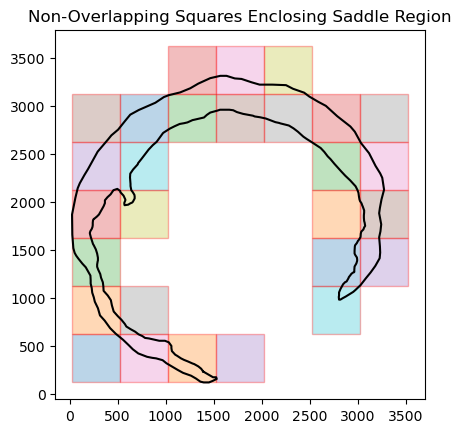

In [13]:
# Define square size
square_size = 500
# square_size = 1200  # Adjust as necessary

# Generate non-overlapping square regions
non_overlapping_squares = crop_polygon_to_non_overlapping_squares(polygon_roi, square_size)

# Visualization
fig, ax = plt.subplots()
# Plot the original polygon
x, y = polygon_roi.exterior.xy
ax.plot(x, y, 'k-', label="Saddle-shaped Polygon")  # Black for polygon

# Plot the square regions
for square in non_overlapping_squares:
    print("square:", square)
    x, y = square.exterior.xy
    print(" x:", x,"\n", "y:", y)
    ax.fill(x, y, edgecolor='red', alpha=0.3, label="Red Square")

# Add labels and legend
ax.set_title(f"Non-Overlapping Squares Enclosing Saddle Region")
ax.set_aspect('equal', 'box')
# ax.legend(loc="upper left")
plt.show()